In [1]:
import os
from dotenv import load_dotenv
load_dotenv(os.path.join("..", ".env"), override=True)

True

In [11]:
import json

from rich.console import Console
from rich.panel import Panel
from rich.text import Text

console = Console()


def format_message_content(message):
    """Convert message content to displayable string."""
    parts = []
    tool_calls_processed = False

    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get("type") == "text":
                parts.append(item["text"])
            elif item.get("type") == "tool_use":
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2, ensure_ascii=False)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if (
        not tool_calls_processed
        and hasattr(message, "tool_calls")
        and message.tool_calls
    ):
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2, ensure_ascii=False)}")
            parts.append(f"   ID: {tool_call['id']}")

    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting."""
    for m in messages:
        msg_type = m.__class__.__name__.replace("Message", "")
        content = format_message_content(m)

        if msg_type == "Human":
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == "Ai":
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == "Tool":
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility."""
    return format_messages(messages)


def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Display a prompt with rich formatting and XML tag highlighting.

    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r"<[^>]+>", style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(
        r"##[^#\n]+", style="bold magenta"
    )  # Highlight headers
    formatted_text.highlight_regex(
        r"###[^#\n]+", style="bold cyan"
    )  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(
        Panel(
            formatted_text,
            title=f"[bold green]{title}[/bold green]",
            border_style=border_style,
            padding=(1, 2),
        )
    )

# more expressive runner
async def stream_agent(agent, query, config=None):
    async for graph_name, stream_mode, event in agent.astream(
        query,
        stream_mode=["updates", "values"], 
        subgraphs=True,
        config=config
    ):
        if stream_mode == "updates":
            print(f'Graph: {graph_name if len(graph_name) > 0 else "root"}')
            
            node, result = list(event.items())[0]
            print(f'Node: {node}')
            
            for key in result.keys():
                if "messages" in key:
                    # print(f"Messages key: {key}")
                    format_messages(result[key])
                    break
        elif stream_mode == "values":
            current_state = event

    return current_state

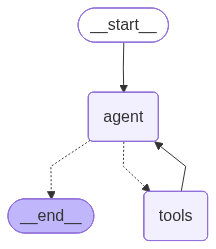

In [ ]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def calculator(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    return result

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
# Create agent using create_react_agent directly

SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = ChatGroq(temperature=0, model_name= "qwen/qwen3-32b")
tools = [calculator]

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    # state_schema=AgentState,  # default
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
# Example usage
result1 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

result1

{'messages': [HumanMessage(content='What is 3.1 * 4.2?', additional_kwargs={}, response_metadata={}, id='fef7eda8-28b0-4dfe-9408-730d0377bce9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c2rq6ca6c', 'function': {'arguments': '{"a":3.1,"b":4.2,"operation":"multiply"}', 'name': 'calculator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 365, 'total_tokens': 521, 'completion_time': 0.282763561, 'prompt_time': 0.019959742, 'queue_time': 0.205630128, 'total_time': 0.302723303}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ea28294c-5ab2-4710-bcca-a12559235756-0', tool_calls=[{'name': 'calculator', 'args': {'a': 3.1, 'b': 4.2, 'operation': 'multiply'}, 'id': 'c2rq6ca6c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 365, 'output_tokens': 156, 'total_tokens': 521}),
  ToolMessage(content='13.020000000000001', name='calcula

In [12]:
format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2,                                                                                                     │
│   "operation": "multiply"                                                                                       │
│ }                                                                                                               │
│    ID: c2rq6ca6c                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result of multiplying 3.1 by 4.2 is **13.02**.                                                              │
│                                                                                                                 │
│ The slight decimal imprecision (e.g., 13.020000000000001) is due to how computers handle floating-point         │
│ arithmetic, but the correct answer is effectively **13.02**.                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
result1["messages"]

[HumanMessage(content='What is 3.1 * 4.2?', additional_kwargs={}, response_metadata={}, id='fef7eda8-28b0-4dfe-9408-730d0377bce9'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c2rq6ca6c', 'function': {'arguments': '{"a":3.1,"b":4.2,"operation":"multiply"}', 'name': 'calculator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 365, 'total_tokens': 521, 'completion_time': 0.282763561, 'prompt_time': 0.019959742, 'queue_time': 0.205630128, 'total_time': 0.302723303}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ea28294c-5ab2-4710-bcca-a12559235756-0', tool_calls=[{'name': 'calculator', 'args': {'a': 3.1, 'b': 4.2, 'operation': 'multiply'}, 'id': 'c2rq6ca6c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 365, 'output_tokens': 156, 'total_tokens': 521}),
 ToolMessage(content='13.020000000000001', name='calculator', id='6b6cc

In [16]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

res = {"messages": messages_to_dict(result1["messages"])}
print(type(res))
res

<class 'dict'>


{'messages': [{'type': 'human',
   'data': {'content': 'What is 3.1 * 4.2?',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'fef7eda8-28b0-4dfe-9408-730d0377bce9',
    'example': False}},
  {'type': 'ai',
   'data': {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'c2rq6ca6c',
       'function': {'arguments': '{"a":3.1,"b":4.2,"operation":"multiply"}',
        'name': 'calculator'},
       'type': 'function'}]},
    'response_metadata': {'token_usage': {'completion_tokens': 156,
      'prompt_tokens': 365,
      'total_tokens': 521,
      'completion_time': 0.282763561,
      'prompt_time': 0.019959742,
      'queue_time': 0.205630128,
      'total_time': 0.302723303},
     'model_name': 'qwen/qwen3-32b',
     'system_fingerprint': 'fp_5cf921caa2',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'run--ea28294c-5ab2-4710-bcca-a12559235756-0',
    'example'

In [18]:
res2 = JSON(res)
print(type(res2))
res2

<class 'IPython.core.display.JSON'>


<IPython.core.display.JSON object>

dict_keys([])

In [19]:
from langgraph.prebuilt.chat_agent_executor import AgentState

def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class CalcState(AgentState):
    """Graph State."""
    ops: Annotated[List[str], reduce_list]



In [20]:
@tool
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],   # not sent to LLM
    tool_call_id: Annotated[str, InjectedToolCallId] # not sent to LLM
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    ops = [f"({operation}, {a}, {b})," ]
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ],
        }
    )

In [22]:
SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

tools = [calculator_wstate]  # new tool

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

In [28]:
# Example usage
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 2 * 3 + 4 / 2?",
            }
        ],
    }
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 2 * 3 + 4 / 2?                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "a": 2,                                                                                                       │
│   "b": 3,                                                                                                       │
│   "operation": "multiply"                                                                                       │
│ }                                                                                                               │
│    ID: g1bed7ybm                                                                                                │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "a": 4,                                                                                                       │
│   "b": 2,                                                                                                       │
│   "operation": "divide"                                                                                         │
│ }                                                                                                               │
│    ID: c1r42pfkq                                                                                                │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "a": 6,                                                                                                       │
│   "b": 2,                                                                                                       │
│   "operation": "add"                                                                                            │
│ }                                                                                                               │
│    ID: mk7xjphcp                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 6                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 2.0                                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 8                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result of the calculation $2 \times 3 + 4 \div 2$ is **8**.                                                 │
│                                                                                                                 │
│ **Step-by-Step Explanation:**                                                                                   │
│ 1. **Multiplication:** $2 \times 3 = 6$                                                                         │
│ 2. **Division:** $4 \div 2 = 2.0$                                                                               │
│ 3. **Addition:** $6 + 2.0 = 8$                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [31]:
result3

{'messages': [HumanMessage(content='What is 2 * 3 + 4 / 2?', additional_kwargs={}, response_metadata={}, id='0e8b8d2e-eeab-4577-a176-a0d7497567f3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g1bed7ybm', 'function': {'arguments': '{"a":2,"b":3,"operation":"multiply"}', 'name': 'calculator_wstate'}, 'type': 'function'}, {'id': 'c1r42pfkq', 'function': {'arguments': '{"a":4,"b":2,"operation":"divide"}', 'name': 'calculator_wstate'}, 'type': 'function'}, {'id': 'mk7xjphcp', 'function': {'arguments': '{"a":6,"b":2,"operation":"add"}', 'name': 'calculator_wstate'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 434, 'prompt_tokens': 369, 'total_tokens': 803, 'completion_time': 0.789467686, 'prompt_time': 0.023325779, 'queue_time': 0.199114384, 'total_time': 0.812793465}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--982ae661-6e54-4288-95e8-5a7d4452d8d3-0